# Pendulum with UKF
θ'' = -g * sin(θ)

X = [θ, θ']

X' = [θ', θ'']

X' = [θ', -g * sin(θ)] = f(X)

[a great reference](https://probml.github.io/dynamax/notebooks/nonlinear_gaussian_ssm/ekf_ukf_pendulum.html)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint
import sympy as sym

## Backgraound: Sigma Points and Unscented Transform

![image.png](imgs/UTParameters.png)

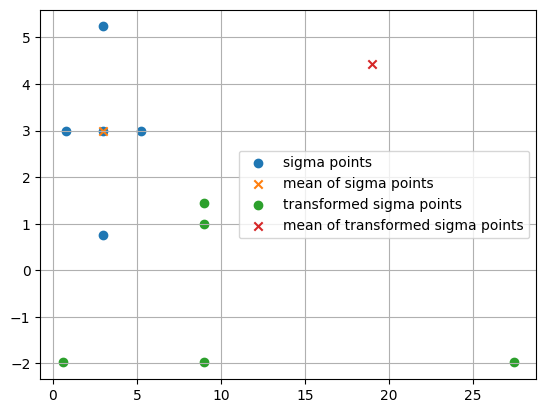

In [4]:
# sigma points
# assume mean is 0
# assume covariance is 1e2
X = np.zeros((2, 1))+3
P = np.eye(2) * 1e1
alpha = 0.5
kappa = 0
beta = 2
L = 2
lam = alpha ** 2 * (L + kappa) - L

# 2n+1 = 5
SigmaPoints = np.zeros((2, 5))
SigmaPoints[:, 0] = X[:, 0]
SigmaPoints[:, 1] = X[:, 0] + np.sqrt((L+lam) * P[:, 0])
SigmaPoints[:, 2] = X[:, 0] + np.sqrt((L+lam) * P[:, 1])
SigmaPoints[:, 3] = X[:, 0] - np.sqrt((L+lam) * P[:, 0])
SigmaPoints[:, 4] = X[:, 0] - np.sqrt((L+lam) * P[:, 1])

# weights
Wm = np.zeros((1, 5))
Wm[0, 0] = lam / (L + lam)
Wm[0, 1:] = 1 / (2 * (L + lam))
Wc = np.zeros((1, 5))
Wc[0, 0] = lam / (L + lam) + (1 - alpha ** 2 + beta)
Wc[0, 1:] = 1 / (2 * (L + lam))


# unscented transform
def g(x):
    return np.array([x[0, :] ** 2, np.cos((x[1, :]))*2])

Y = g(SigmaPoints)
Y_mean = np.sum(Wm * Y, axis=1).reshape(-1, 1)
Y_cov = np.sum(Wc * (Y - Y_mean) * (Y - Y_mean), axis=1)

# plot transformed sigma points
fig, ax = plt.subplots()
ax.scatter(SigmaPoints[0, :], SigmaPoints[1, :], label='sigma points')
ax.scatter(SigmaPoints[0, 0], SigmaPoints[1, 0], label='mean of sigma points', marker='x')
ax.scatter(Y[0, :], Y[1, :], label='transformed sigma points')
ax.scatter(Y_mean[0, :], Y_mean[1, :], label='mean of transformed sigma points', marker='x')
ax.grid(True)
ax.legend()
plt.show()

## Back to Pendulum Case

### Solve Pendulum Equation

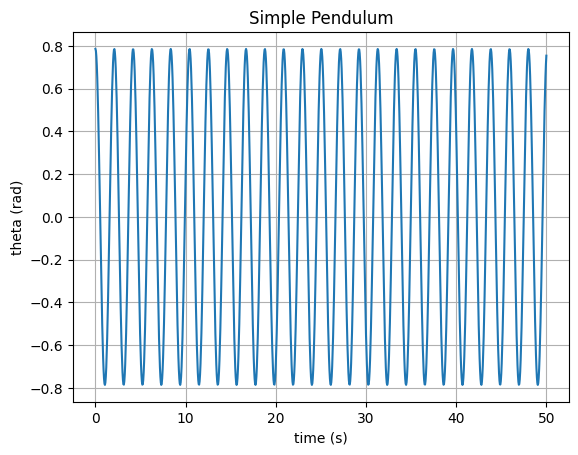

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
import glob
import os

def simple_pendulum_deriv(x, t, m, g, l): 
# The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = -(m * g * l * np.sin(x[0])) 
    return nx

def plot_orbit( x0 ):
    # Plot the phase space of the pendulum
    # Pick ts to be sufficiently large (by inspection) to make sure
    # that all of the cases of interest will have reached their 
    # homoclinic orbit
    ts = np.linspace(0.0, 50.0, 1001)
    ys = odeint(simple_pendulum_deriv, x0, ts, args = (1.0, 9.8, 1.0))
    plt.plot(ys[:,0], ys[:,1])

def plot_orbit2( x0 ):
    ts = np.linspace(0.0, 50.0, 1001)
    ys = odeint(simple_pendulum_deriv, x0, ts, args = (1.0, 9.8, 1.0))
    fig, ax = plt.subplots()
    ax.plot(ts, ys[:,0])
    ax.set(xlabel='time (s)', ylabel='theta (rad)',
        title='Simple Pendulum')
    ax.grid()
    plt.show()


def plot_pendulum(q, length = 1.0):
    xs = [  0.0,  length * np.sin(q[0]) ]
    ys = [  0.0, -length * np.cos(q[0]) ]
    plt.plot( xs, ys, 'b-', linewidth = 3 )
    plt.plot( xs[1], ys[1], 'ro' )
    plt.gca().set_xlim([-1.2, 1.2])
    plt.gca().set_ylim([-1.2, 1.2])
    plt.gca().set_aspect('equal')

def plot_interesting_orbits():
    plt.clf()
    # start with zero velocity at a number of differing angles
    # scipy odeint does some pretty weird things if you have enough
    # velocity to loop around
    plot_orbit(np.array([np.pi * 0.25, 0.0]))
    plot_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_orbit(np.array([np.pi * 0.9, 0.0]))
    plot_orbit(np.array([np.pi * 0.999, 0.0]))
    plt.title('homoclinic orbits for an undamped simpled pendulum')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    plt.show()

plot_orbit2(np.array([np.pi * 0.25, 0.0]))

-g⋅sin(θ(t)) 
─────────────
      l      
d       
──(θ(t))
dt      


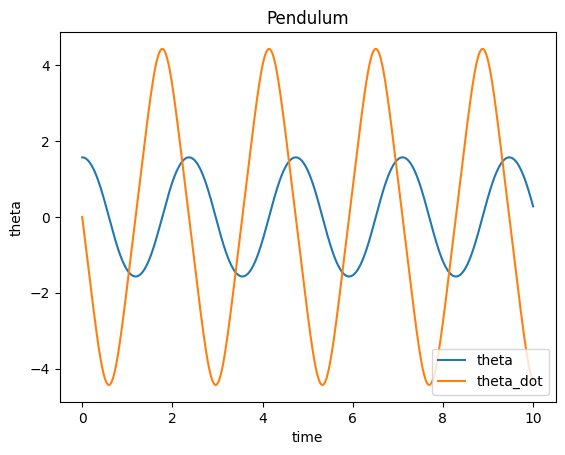

In [26]:
def symbolic_calculation():
    t, l, m, g = sym.symbols('t l m g')
    theta = sym.symbols('theta', cls=sym.Function)
    theta = theta(t)
    theta_dot = sym.diff(theta, t)
    theta_dot_dot = sym.diff(theta_dot, t)

    T = 1/2 * m * l**2 * theta_dot**2
    V = m * g * l * (1 - sym.cos(theta))
    L = T - V

    LE = sym.diff(L, theta) - sym.diff(sym.diff(L, theta_dot), t)
    LE = sym.simplify(LE)
    LE = sym.Eq(LE, 0)

    deriv_2 = sym.solve(LE, theta_dot_dot)[0]
    deriv_1 = theta_dot
    sym.pprint(deriv_2)
    sym.pprint(deriv_1)

    deriv2_f = sym.lambdify((g,l,theta), deriv_2)
    deriv1_f = sym.lambdify((theta_dot), deriv_1)
    return deriv2_f, deriv1_f

deriv2_f, deriv1_f = symbolic_calculation()

def calculate_derivatives(X, t, g, l):
    theta = X[0]
    theta_dot = X[1]
    theta_dot_dot = deriv2_f(g,l,theta)
    theta_dot = deriv1_f(theta_dot)
    return [theta_dot, theta_dot_dot]

t = np.linspace(0, 10, 1000)
g = 9.81
l = 1
ans = odeint(calculate_derivatives, [np.pi/2, 0], t=t,args=(g,l))
fig,axis = plt.subplots(1,1)
plt.plot(t, ans[:,0], label='theta')
plt.plot(t, ans[:,1], label='theta_dot')
axis.legend()
axis.set_xlabel('time')
axis.set_ylabel('theta')
axis.set_title('Pendulum')
plt.show()

### Unscented Kalman Filter to track pendulum

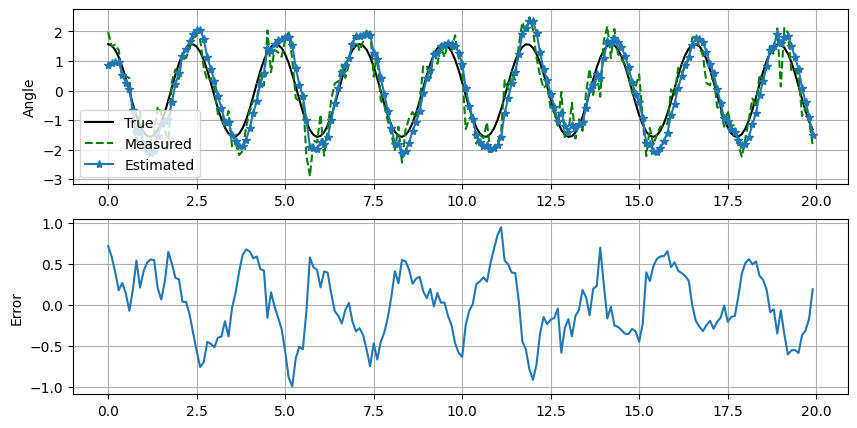

In [24]:
# θ'' = -g * sin(θ)
# X = [θ, θ']
# θ = θ + θ' * dt
# θ' = θ' - g * sin(θ) * dt
n = 2
g = 9.81
m = 1
l = 1
alpha = np.pi
beta = 2
kappa = 0
lam = alpha**2 * (n + kappa) - n
c = alpha**2 * (n + kappa)

def f(X, dt):
    theta = X[0]
    theta_dot = X[1]
    theta_dot_dot = -g/l * np.sin(theta)
    return np.array([theta_dot, theta_dot_dot]) * dt + X

def h(X):
    return np.array([X[0]])

def sigma_points(x, P):
    xsg = np.zeros((2*n+1, n))
    # print(x.shape, P.shape,xsg[0].shape)
    xsg[0] = x
    Psqrt = np.linalg.cholesky(P)
    for i in range(n):
        xsg[i+1] = x + Psqrt[i]*np.sqrt(c)
        xsg[i+1+n] = x - Psqrt[i]*np.sqrt(c)
    return xsg

def predict(x, P, dt):
    xsg = sigma_points(x, P)
    xsg = f(xsg.T, dt).T
    zsg = h(xsg.T).T
    # print(xsg.shape, zsg.shape)

    wm = np.ones((2*n+1,1)) / (2*c)
    wm[0] = lam / c
    xsg_mean = np.sum(wm * xsg, axis=0)
    zsg_mean = np.sum(wm * zsg, axis=0)
    # print(xsg_mean.shape, zsg_mean.shape)
    assert xsg_mean.shape == (xsg.shape[1],)
    assert zsg_mean.shape == (zsg.shape[1],)
    return xsg, zsg, xsg_mean, zsg_mean

def update(xsg, zsg, xsg_mean, zsg_mean, z, Q, R):
    wc = np.ones(2*n+1) / (2*c)
    wc[0] = lam / c + (1 - alpha**2 + beta)
    Pzz = (wc * (zsg - zsg_mean).T )@(zsg - zsg_mean) + R # 1x5 * 5x1 = 1x1
    Pxx = (wc * (xsg - xsg_mean).T )@(xsg - xsg_mean) + Q # 2x5 * 5x2 = 2x2
    assert Pzz.shape == (zsg.shape[1], zsg.shape[1])
    assert Pxx.shape == (xsg.shape[1], xsg.shape[1])

    Pxz = (wc * (xsg - xsg_mean).T)@(zsg - zsg_mean) # 1x5 * 5x1 = 1x1
    assert Pxz.shape == (xsg.shape[1], zsg.shape[1])

    K = Pxz @ np.linalg.inv(Pzz)
    # print(xsg_mean.shape, K.shape, (z - zsg_mean).shape, (K @ (z - zsg_mean)).shape)
    x_corr = xsg_mean + K @ (z - zsg_mean)
    P_corr = Pxx - K @ Pzz @ K.T
    return x_corr, P_corr

def state_transfer(x, t, g, l): 
    # The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = -(g * l * np.sin(x[0])) 
    return nx

X = [30*np.pi/180, 0]
P = np.diag([1,1])* 0.1
dt = 0.1
n_steps = 200
t = np.arange(0, n_steps*dt, dt)
ans = odeint(state_transfer, [np.pi/2, 0], t=t, args=(g,l))
angle = ans[:,0]
dangle = ans[:,1]
zs = angle + np.random.randn(n_steps)*0.5
Q = np.array([[dt**3/3, dt**2/2], [dt**2/2, dt]]) * 0.1
R = 0.7**3

Xs = []
X = np.array(X)
for i in range(n_steps):
    # print(i)
    xsg, zsg, xsg_mean, zsg_mean = predict(X, P, dt)
    X, P = update(xsg, zsg, xsg_mean, zsg_mean, zs[i], Q, R)
    # print(X.shape)
    Xs.append(X)
    
Xs = np.array(Xs)
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(t, angle,'k', label='True')
ax[0].plot(t, zs,'g--', label='Measured')
ax[0].plot(t, Xs[:,0],'*-', label='Estimated')
ax[0].set_ylabel('Angle')
ax[0].grid()
ax[0].legend()
ax[1].plot(t, angle - Xs[:,0],'-', label='Error')
ax[1].set_ylabel('Error')
ax[1].grid()
plt.show()

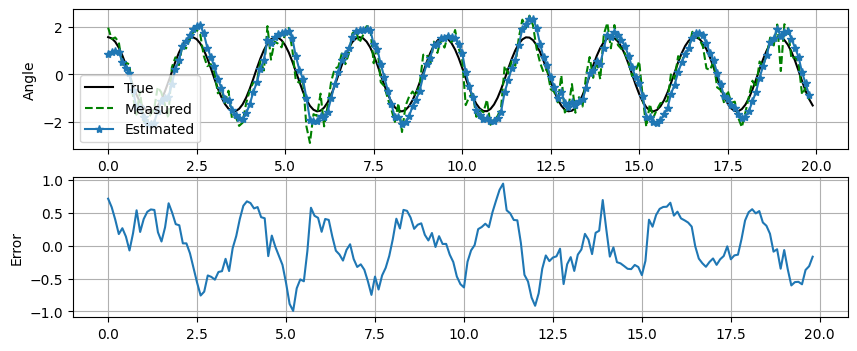

In [25]:
fig,ax = plt.subplots(2,1,figsize=(10,4))

def update(i):
    ax[0].clear()
    ax[0].plot(t, angle,'k', label='True')
    ax[0].plot(t[:i], zs[:i],'g--', label='Measured')
    ax[0].plot(t[:i], Xs[:i,0],'*-', label='Estimated')
    ax[0].set_ylabel('Angle')
    ax[0].grid()
    ax[0].legend()
    ax[1].clear()
    ax[1].plot(t[:i], angle[:i] - Xs[:i,0],'-', label='Error')
    ax[1].set_ylabel('Error')
    ax[1].grid()
    
ani = animation.FuncAnimation(fig, update, frames=len(t), interval=200)
ani.save('UKF_motion_estimation.gif', writer='imagemagick')
plt.show()